In [1]:
import os
import torch
import time
from lung_dataset import Lung_Dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from torchsummary import summary

model_path = "./model/"

In [2]:
ld_train1 = Lung_Dataset("train", "binary1")
ld_val1 = Lung_Dataset("val", "binary1")
ld_test1 = Lung_Dataset("test", "binary1")

ld_train2 = Lung_Dataset("train", "binary2")
ld_val2 = Lung_Dataset("val", "binary2")
ld_test2 = Lung_Dataset("test", "binary2")

print(ld_train1.describe())


This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5856 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid: 1345 images.
 - train_infected_noncovid, in folder ./dataset/train/infected/non-covid: 2530 images.
 - val_normal, in folder ./dataset/val/normal: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid: 9 images.
 - val_infected_noncovid, in folder ./dataset/val/infected/non-covid: 8 images.
 - test_normal, in folder ./dataset/test/normal: 234 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid: 139 images.
 - test_infected_noncovid, in folder ./dataset/test/infected/non-covid: 

## Classifier#1 between normal and infected

In [3]:
class Model_binary_1(nn.Module):
    def __init__(self):
        super(Model_binary_1, self).__init__()
        
        # input img = 150x150
        # First block of Residual Block (3x3x16/2) + Pooling(2x2/2), output size = 19x19x16
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.conv_skip1 = nn.Conv2d(1, 16, 1, 4)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Second block of Residual Block (3x3x32/1) + Pooling(2x2/2), output size = 9x9x32
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv_skip2 = nn.Conv2d(16, 32, 1, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Third block of Residual Block (3x3x32/1) + Global Average Pooling, output size = 64
        self.conv5 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv6 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv_skip3 = nn.Conv2d(32, 64, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        # FC layer
        self.fc1 = nn.Linear(64, 2)


    def forward(self, x):
        # Block 1
        residual1 = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        residual1 =  F.relu(self.conv_skip1(residual1))
        x += residual1
        x = self.pool1(x)
        
        # Block 2
        residual2 = x
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        residual2 =  F.relu(self.conv_skip2(residual2))
        x += residual2
        x = self.pool2(x)
        
        # Block 3
        residual3 = x
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        residual3 =  F.relu(self.conv_skip3(residual3))
        x += residual3
        x = self.gap(x)
        x = torch.flatten(x, 1)
        # FC
        x = self.fc1(x)

        output = F.softmax(x, dim=1)
        return output


In [4]:
model = Model_binary_1()
print(summary(model, (1,150,150), device="cpu"))

# Define Parameter here:
model_type = "binary1"
batch_size = 128
n_epochs = 20
lr = 0.00001
checkpoint_interval = 1
train_loss_ls = []
val_loss_ls = []

time_stamp = str(time.time()).split(".")[0]
current_model_path = model_path + f"{model_type}-{time_stamp}-{n_epochs}e-{batch_size}b/"
os.mkdir(current_model_path)

train_loader1 = DataLoader(ld_train1, batch_size=batch_size, shuffle=True)
val_loader1 = DataLoader(ld_val1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(ld_test1, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 75, 75]             160
            Conv2d-2           [-1, 16, 38, 38]           2,320
            Conv2d-3           [-1, 16, 38, 38]              32
         MaxPool2d-4           [-1, 16, 19, 19]               0
            Conv2d-5           [-1, 32, 19, 19]           4,640
            Conv2d-6           [-1, 32, 19, 19]           9,248
            Conv2d-7           [-1, 32, 19, 19]             544
         MaxPool2d-8             [-1, 32, 9, 9]               0
            Conv2d-9             [-1, 64, 9, 9]          18,496
           Conv2d-10             [-1, 64, 9, 9]          36,928
           Conv2d-11             [-1, 64, 9, 9]           2,112
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                    [-1, 2]             130
Total params: 74,610
Trainable params: 

In [6]:
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    train_loss = 0.0
    validation_loss = 0.0
#     total = 0

    # Training
    for i, data in enumerate(train_loader1, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
#         print(f"current loss: {loss.item()}")
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        
    # Validation
    for _, data in enumerate(val_loader1, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        validation_loss += loss.item()
    train_loss_ls.append(train_loss/len(train_loader1))
    val_loss_ls.append(validation_loss/len(val_loader1))
    print(f"epoch {epoch}: {train_loss/len(train_loader1)} train loss, {validation_loss/len(val_loader1)} val loss")
    
    if (epoch+1)%checkpoint_interval==0:
        filepath = current_model_path + f"b{batch_size}-e{epoch}.pt"
        torch.save(model.state_dict(), filepath)
        
print("Finished training")


[1,    10] loss: 0.720
[1,    20] loss: 0.715
[1,    30] loss: 0.715
[1,    40] loss: 0.710
epoch 0: 0.714839872790546 train loss, 0.7046380043029785 val loss
[2,    10] loss: 0.707
[2,    20] loss: 0.704
[2,    30] loss: 0.702
[2,    40] loss: 0.699
epoch 1: 0.7027087749504461 train loss, 0.6949296593666077 val loss
[3,    10] loss: 0.694
[3,    20] loss: 0.691
[3,    30] loss: 0.686
[3,    40] loss: 0.682
epoch 2: 0.6881421266532526 train loss, 0.6824109554290771 val loss
[4,    10] loss: 0.676
[4,    20] loss: 0.671
[4,    30] loss: 0.667
[4,    40] loss: 0.664
epoch 3: 0.6692588518305522 train loss, 0.6666021943092346 val loss
[5,    10] loss: 0.655
[5,    20] loss: 0.647
[5,    30] loss: 0.647
[5,    40] loss: 0.636
epoch 4: 0.6455767111080449 train loss, 0.649929940700531 val loss
[6,    10] loss: 0.630
[6,    20] loss: 0.623
[6,    30] loss: 0.616
[6,    40] loss: 0.612
epoch 5: 0.6211958992771986 train loss, 0.636121928691864 val loss
[7,    10] loss: 0.617
[7,    20] loss: 0.6

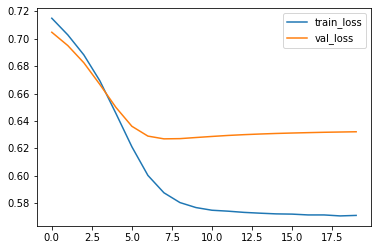

In [7]:
plt.plot(train_loss_ls, label = "train_loss")
plt.plot(val_loss_ls, label = "val_loss")
plt.legend()
plt.savefig(current_model_path+'train_val_loss.png')
plt.show()

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader1:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 61 %


## Classifier#2 between infected-covid and infected-noncovid

In [10]:
model2 = Model_binary_1()
print(summary(model, (1,150,150), device="cpu"))

# Define Parameter here:
model_type = "binary2"
batch_size = 128
n_epochs = 30
lr = 0.00001
checkpoint_interval = 1
train_loss_ls = []
val_loss_ls = []

time_stamp = str(time.time()).split(".")[0]
current_model_path = model_path + f"{model_type}-{time_stamp}-{n_epochs}e-{batch_size}b/"
os.mkdir(current_model_path)

train_loader2 = DataLoader(ld_train2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(ld_val2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(ld_test2, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr )


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 75, 75]             160
            Conv2d-2           [-1, 16, 38, 38]           2,320
            Conv2d-3           [-1, 16, 38, 38]              32
         MaxPool2d-4           [-1, 16, 19, 19]               0
            Conv2d-5           [-1, 32, 19, 19]           4,640
            Conv2d-6           [-1, 32, 19, 19]           9,248
            Conv2d-7           [-1, 32, 19, 19]             544
         MaxPool2d-8             [-1, 32, 9, 9]               0
            Conv2d-9             [-1, 64, 9, 9]          18,496
           Conv2d-10             [-1, 64, 9, 9]          36,928
           Conv2d-11             [-1, 64, 9, 9]           2,112
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                    [-1, 2]             130
Total params: 74,610
Trainable params: 

In [11]:
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    train_loss = 0.0
    validation_loss = 0.0
#     total = 0

    # Training
    for i, data in enumerate(train_loader2, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
#         print(f"current loss: {loss.item()}")
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        
    # Validation
    for _, data in enumerate(val_loader2, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        validation_loss += loss.item()
    train_loss_ls.append(train_loss/len(train_loader2))
    val_loss_ls.append(validation_loss/len(val_loader2))
    print(f"epoch {epoch}: {train_loss/len(train_loader2)} train loss, {validation_loss/len(val_loader2)} val loss")
    
    if (epoch+1)%checkpoint_interval==0:
        filepath = current_model_path + f"b{batch_size}-e{epoch}.pt"
        torch.save(model.state_dict(), filepath)
        
print("Finished training")


[1,    10] loss: 0.657
[1,    20] loss: 0.672
[1,    30] loss: 0.647
epoch 0: 0.6582743352459323 train loss, 0.8325642347335815 val loss
[2,    10] loss: 0.647
[2,    20] loss: 0.653
[2,    30] loss: 0.670
epoch 1: 0.6565374635880993 train loss, 0.8238791823387146 val loss
[3,    10] loss: 0.658
[3,    20] loss: 0.659
[3,    30] loss: 0.643
epoch 2: 0.6555001678005341 train loss, 0.8079172372817993 val loss
[4,    10] loss: 0.662
[4,    20] loss: 0.644
[4,    30] loss: 0.647
epoch 3: 0.6493922798864303 train loss, 0.7890425324440002 val loss
[5,    10] loss: 0.662
[5,    20] loss: 0.645
[5,    30] loss: 0.639
epoch 4: 0.6473283979200548 train loss, 0.7741398811340332 val loss
[6,    10] loss: 0.650
[6,    20] loss: 0.653
[6,    30] loss: 0.641
epoch 5: 0.6460719320081896 train loss, 0.7680836319923401 val loss
[7,    10] loss: 0.647
[7,    20] loss: 0.654
[7,    30] loss: 0.640
epoch 6: 0.6480439882124623 train loss, 0.7659997940063477 val loss
[8,    10] loss: 0.644
[8,    20] loss: 0

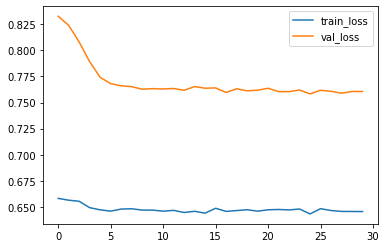

In [12]:
plt.plot(train_loss_ls, label = "train_loss")
plt.plot(val_loss_ls, label = "val_loss")
plt.legend()
plt.savefig(current_model_path+'train_val_loss.png')
plt.show()

In [14]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader2:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1